In [1]:
import tensorflow
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import cv2 as cv

In [2]:
# load the model
model = load_model('inceptionV3.h5')

In [3]:
test_image_path = 'F:/Large Datasets/Malaria Cell Images/Parasitized/C33P1thinF_IMG_20150619_121229a_cell_177.png'
img = image.load_img(test_image_path, target_size = (150,150))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = x/255

# prediction probabilities for the 2 classes
pred = model.predict(x)

# predicted class
pred_class = np.argmax(pred[0])

if pred_class == 0:
    print("REPORT: The cell is Parasitized. Malaria Detected. ")
else:
    print("REPORT: The cell is not Infected.")

REPORT: The cell is Parasitized. Malaria Detected. 


# Grad-CAM (Class Activation Map)

In [4]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

# Display
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [5]:
# prepare the input image
def get_img_array(img_path, size):
    # `img` is a PIL image of size 150x150
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (150, 150, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 150, 150, 3)
    array = np.expand_dims(array, axis=0)
    return array

In [6]:
# create the heatmap
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [7]:
# create the superimposed image with grad-cam alogorithm
def gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=1):
    # Load the original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    return superimposed_img

In [8]:
img_size = (150, 150)
last_conv_layer_name = 'mixed7'

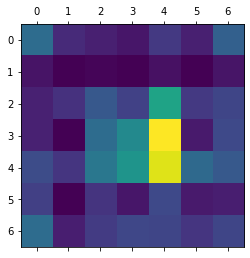

In [9]:
img_array = (get_img_array(test_image_path, size=img_size))/255
preds = model.predict(img_array)

heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# heatmap
plt.matshow(heatmap)
plt.show()

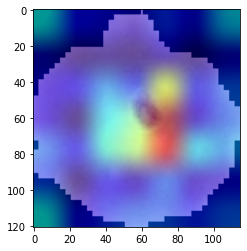

In [10]:
# superimposed image
plt.imshow(gradcam(test_image_path, heatmap))
plt.show()